In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse import spdiags, block_diag
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from time import perf_counter
import matplotlib.animation as animation
import rasterio

# Motivation and Problem Background

As someone from the PNW, I have had the unfortunate experience of watching the number of wildfires climb over the past 10-15 years. There have been multiple days each summer where the air quality index (a measure of particulate matter in the air) is so high, that I won't go outside. While fire is something that has been around for more than 400 million years, we continue to battle with the its impact on a growing population. I have family who are wildland firefighters and know even more first responders, so this matter is close to home, in geography and in relationships.

The problem I set out to explore is the spread of fire across a variety of factors, namely topography, wind, and fuel. While this method is accurate to the real world, I made some simplifications in the interest of time and due to my limited knowledge of the domain. 

<strong><u> Goal</u></strong>: Model a wildfire (temperature and remaining fuel) which starts at a particular location [x,y] across a span of time [0,t<sub>end</sub>]. 

# Problem Setup
**Parameters**
- $[x,y]$ = spatial domain in question
- $[0,t_{end}]$ = time evaluation range
- $k$ = diffusion coefficient
- $\epsilon$ = the inverse of the activation energy of the fuel
- $\alpha$ = natural convection coefficient
- $q$ = reaction heat
- $u_{pc}$ = phase change threshold

**Functions**
- $u(x,y,t) = u_{x,y,t} = k\Delta u - \upsilon \cdot \nabla u + f(u,\beta)$ -> temperature at time t and location x,y
- $\beta(x,y,t) = \beta_{x,y,t} = g(u,\beta)$ -> amount of fuel left at time t and location x,y
    - $g(u,\beta) = -\mathcal{H}_{pc}(u) \frac{\epsilon}{q} \beta e^{\frac{u}{1+\epsilon u}}$
    - $\mathcal{H}_{pc}$ is the Heaviside function centered at $u_{pc}$
- $\upsilon(x,y,t)$ = $w(t) + \nabla Z(x,y)$ -> wind and tompography vector field
    - $w(t)$ -> vector field correlating to the wind at time t
    - $Z(x,y)$ -> vector field correponding to topography at time t and location x,y
- $f(u,\beta)$ -> nonlinear heat source
    - $f(u,\beta) = \mathcal{H}_{pc}(u) \beta e^{\frac{u}{1+\epsilon u}} - \alpha u$


In [8]:
# --- 1. Domain & Parameters ---
m = 250            # Grid points per axis
L = 20.0           # Physical domain length (-L to L)
delta = (2*L) / (m-1)
x = np.linspace(-L, L, m)
y = np.linspace(-L, L, m)
X, Y = np.meshgrid(x, y)

# Physics Parameters (Dimensionless)
k = 0.1            # Diffusion coefficient
epsilon = 0.2      # Inverse activation energy
alpha = 0.05       # Natural convection/cooling
q = 1.0            # Reaction heat
u_pc = 0.1         # Phase change threshold (Ignition temp)

# --- 2. Finite Difference Operators (Method of Lines) ---
# We construct 1D operators first, then upgrade to 2D using Kronecker products.
# This ensures mathematically correct derivatives on a flattened vector.

# Identity
I = sp.eye(m)

# 1D Laplacian (Second Derivative) with Neumann BCs (flux = 0 at edges)
e = np.ones(m)
data = [e, -2*e, e]
offsets = [-1, 0, 1]
D2_1d = sp.spdiags(data, offsets, m, m).tolil()
# Neumann BC adjustment: derivative at boundary is zero -> mirrors neighbor
D2_1d[0, 1] = 2; D2_1d[-1, -2] = 2 
D2_1d = D2_1d / (delta**2)

# 1D Gradient (First Derivative - Central Difference)
data_grad = [-0.5*e, 0.5*e] # Central diff: (u_{i+1} - u_{i-1}) / 2dx
offsets_grad = [-1, 1]
D1_1d = sp.spdiags(data_grad, offsets_grad, m, m) / delta


# Gradients: dx operates on rows, dy operates on columns
Dx = sp.kron(I, D1_1d) # Partial wrt x
Dy = sp.kron(D1_1d, I) # Partial wrt y

# Construct 2D Operators using Kronecker Products
# Laplacian: L_2D = I x D_xx + D_yy x I
Laplacian = sp.kron(I, D2_1d) + sp.kron(D2_1d, I)

print(f"System Size: {Laplacian.shape}")

System Size: (62500, 62500)


# Topography and Wind Fields
- The first topography had no issues near the boundaries but the valley, esp first valley, had issues with the vector calculations meaning the approximation will also have issues. I needed to 0 out the X and Y boundaries after calculating them with 

Vx and Vy shapes:  (62500,) (62500,)


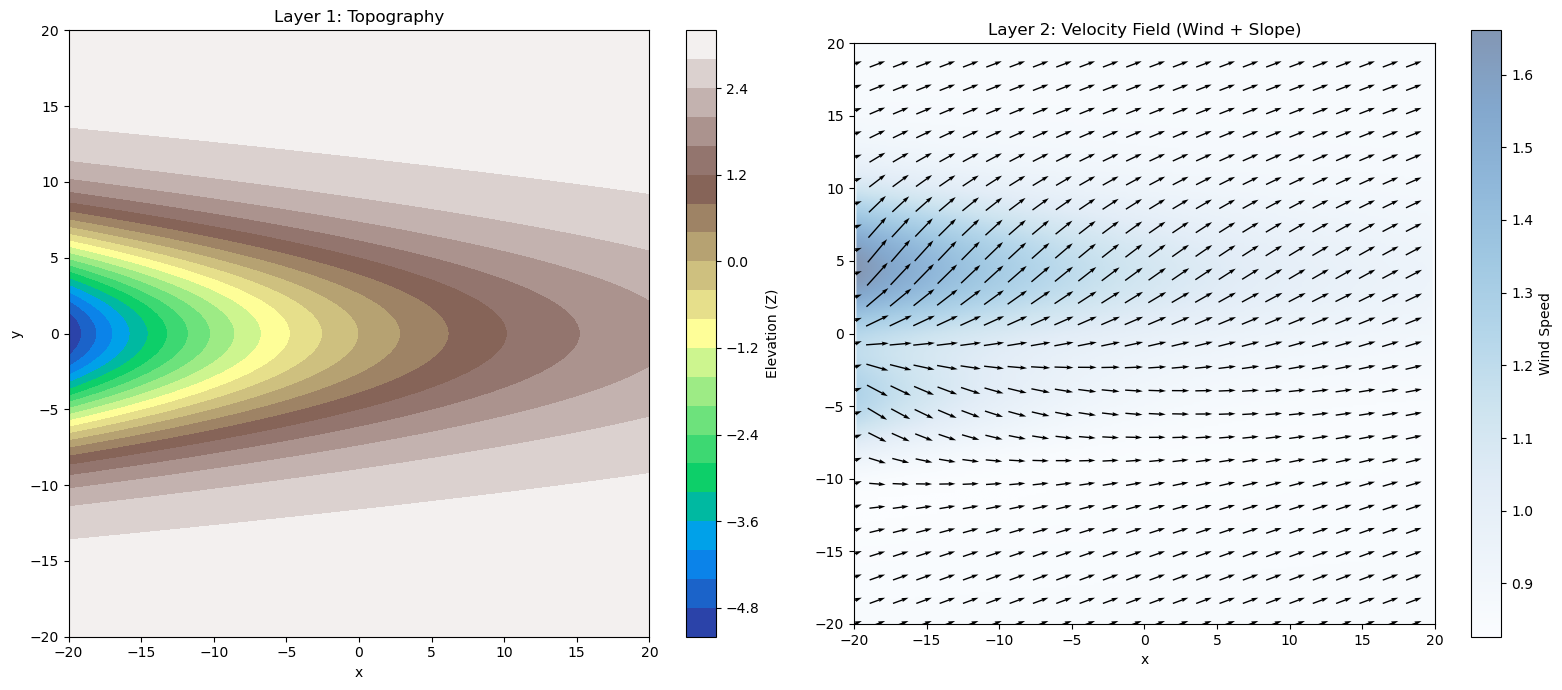

In [23]:
# def calculate_velocity_field(Z, wind_vec):
#     """
#     Calculates the total velocity field: Wind + Slope gradient.
#     """
#     # 1. Calculate Slope (Gradient of Z)
#     # We use np.gradient for dense arrays (easier for plotting setup)
#     # dy is axis 0 (rows), dx is axis 1 (cols)
#     grad_Z_y, grad_Z_x = np.gradient(Z, delta)
    
#     # 2. Add Wind Vector
#     Vx = wind_vec[0] + grad_Z_x
#     Vy = wind_vec[1] + grad_Z_y
    
#     return Vx, Vy, grad_Z_x, grad_Z_y

def visualize_layers(Z, Vx, Vy):
    """
    Visualizes Topography and the resulting Flow Field.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    
    # --- Plot 1: Topography (Height Map) ---
    contour = ax[0].contourf(X, Y, Z, cmap='terrain', levels=20)
    fig.colorbar(contour, ax=ax[0], label='Elevation (Z)')
    ax[0].set_title("Layer 1: Topography")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    # --- Plot 2: Velocity Field (Quiver) ---
    # We decimate the grid (show every 5th arrow) to prevent clutter
    skip = 10
    ax[1].set_title("Layer 2: Velocity Field (Wind + Slope)")
    
    # Background color is slope magnitude
    slope_mag = np.sqrt(Vx**2 + Vy**2)
    im1 = ax[1].imshow(slope_mag, extent=[-L, L, -L, L], origin='lower', cmap='Blues', alpha=0.5)
    fig.colorbar(im1, ax=ax[1], label='Wind Speed')
    # Vector arrows
    ax[1].quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                 Vx[::skip, ::skip], Vy[::skip, ::skip], 
                 color='black', pivot='mid', scale=30)
    
    ax[1].set_xlabel("x")
    
    plt.tight_layout()
    plt.show()

# Topography Z(x,y):
# Z = 3.0 * np.exp(-(X**2 + Y**2) / 50) # Hill
Z = 3.0 - 3.0 * np.exp(-(0.5*X + 0.2*Y**2) / 10.0) # Valley
# Z = 5.0 * np.exp(-((X - 5)**2) / 8.0) # Trench
Z_flatten = Z.reshape(-1)
grad_Z_x_r = Dx @ Z_flatten
grad_Z_y_r = Dy @ Z_flatten

boundary_mask = np.zeros((m, m), dtype=bool)
boundary_mask[0, :] = True   # Bottom edge (Y-min)
boundary_mask[-1, :] = True  # Top edge (Y-max)
boundary_mask[:, 0] = True   # Left edge (X-min)
boundary_mask[:, -1] = True  # Right edge (X-max)
boundary_indices = boundary_mask.reshape(-1)

grad_Z_x = np.copy(grad_Z_x_r)
grad_Z_y = np.copy(grad_Z_y_r)

grad_Z_x[boundary_indices] = 0.0
grad_Z_y[boundary_indices] = 0.0

# Define Wind (blowing North-East)
wind_vector = [0.8, 0.3] 

# Wind w(t): Constant wind blowing North-East
w_x = 0.8
w_y = 0.3

# Total Velocity Field v(x,y) = w + grad(Z)
Vx = w_x + grad_Z_x
Vy = w_y + grad_Z_y
print("Vx and Vy shapes: ", Vx.shape, Vy.shape)
visualize_layers(Z, Vx.reshape(m, m), Vy.reshape(m, m))



# Initial Conditions and Time Span

In [24]:
# Initial Temp: A small spark at (-5, -5)
u0 = 3.0 * np.exp(-((X+15)**2 + (Y)**2) / 2.0)
# Initial Fuel: Uniform everywhere
beta0 = np.ones_like(u0)

# Flatten and combine
y0 = np.concatenate([u0.reshape(-1), beta0.reshape(-1)])

# Time span
t_span = (0, 8.0)
t_eval = np.linspace(0, 8.0, 20)

# Solver

In [28]:
# --- 4. The Reaction-Diffusion System ---

def smoothed_heaviside(u, threshold, k=50):
    """
    Sigmoid approximation of Heaviside step function.
    Strict Heaviside causes ODE solvers to stall at the discontinuity.
    """
    return 0.5 * (np.tanh(k * (u - threshold)) + 1)

def reaction_rate(u, beta):
    # Arrhenius term: exp(u / (1 + eps*u))
    arrhenius = np.exp(u / (1 + epsilon * u))
    # Threshold: Fire only burns if u > u_pc
    H = smoothed_heaviside(u, u_pc)
    return H * beta * arrhenius

def model_rhs(t, state):
    """
    Right Hand Side of the PDE system.
    State is a vector of size 2*m*m (Temperature followed by Fuel).
    """
    n = m * m
    u = state[:n]      # Temperature
    beta = state[n:]   # Fuel

    # 1. Diffusion: k * Laplacian * u
    diff_term = k * (Laplacian @ u)

    # 2. Convection: - v . grad(u)
    # Note: We use element-wise multiplication for spatially varying velocity
    adv_term = - (Vx * (Dx @ u) + Vy * (Dy @ u))

    # 3. Reaction
    rr = reaction_rate(u, beta)
    
    # Heat Source: Reaction - Cooling
    f_u = rr - alpha * u
    
    # Fuel Consumption
    g_beta = -(epsilon / q) * rr

    # Combine terms
    du_dt = diff_term + adv_term + f_u
    dbeta_dt = g_beta

    return np.concatenate([du_dt, dbeta_dt])

t_start = perf_counter()
sol = solve_ivp(
    model_rhs, 
    t_span, 
    y0, 
    method='RK45',
    t_eval=t_eval
)

print(f"Solved in {perf_counter() - t_start:.2f} seconds.")

Solved in 3.64 seconds.


# Animation Creation

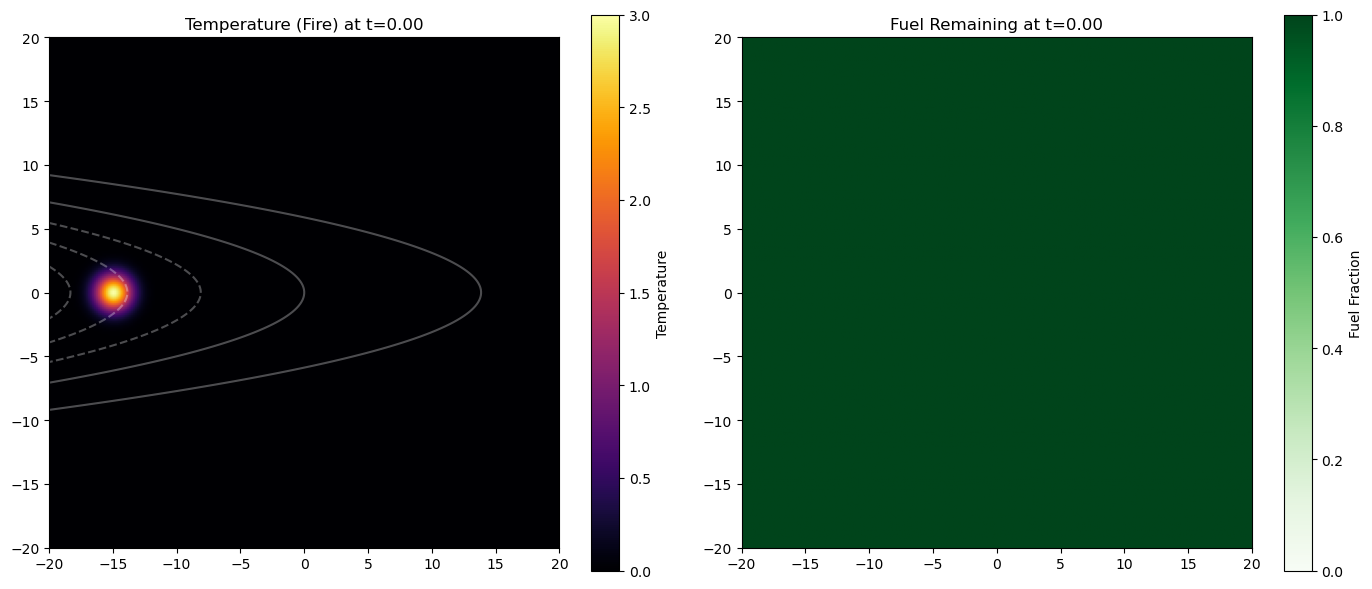

In [29]:
# --- 6. Visualization ---
n = m * m
u_res = sol.y[:n, 0].reshape(m, m)
b_res = sol.y[n:, 0].reshape(m, m)
    
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
# Plot Temperature
im1 = ax[0].imshow(u_res, extent=[-L, L, -L, L], origin='lower', cmap='inferno', vmin=0, vmax=3)
ax[0].set_title(f"Temperature (Fire) at t={sol.t[0]:.2f}")
ax[0].contour(X, Y, Z, colors='white', alpha=0.3) # Show topography lines
fig.colorbar(im1, ax=ax[0], label='Temperature')
    
# Plot Fuel
im2 = ax[1].imshow(b_res, extent=[-L, L, -L, L], origin='lower', cmap='Greens', vmin=0, vmax=1)
ax[1].set_title(f"Fuel Remaining at t={sol.t[0]:.2f}")
fig.colorbar(im2, ax=ax[1], label='Fuel Fraction')
    
plt.tight_layout()


def plot_state(frame):
    u_res = sol.y[:n, frame].reshape(m, m)
    b_res = sol.y[n:, frame].reshape(m, m)
    
    
    # Plot Temperature
    im1.set_data(u_res)
    ax[0].set_title(f"Temperature (Fire) at t={sol.t[frame]:.2f}")
    
    # Plot Fuel
    im2.set_data(b_res)
    ax[1].set_title(f"Fuel Remaining at t={sol.t[frame]:.2f}")
    

    return (im1, im2)

In [30]:
ani = animation.FuncAnimation(fig=fig, 
                              func=plot_state, 
                              frames=len(sol.t), 
                              interval=75,  # 75ms between frames
                              blit=True)


ani.save(
    'simpleFire_Valley45.gif', 
    writer='pillow', 
    fps=10,  # Frames per second (adjust to change speed)
    dpi=150  # Resolution (adjust for quality vs. file size)
)

plt.show()

# Extensions

| **Extension Area** | **Goal** | **Key Task** |
|----------------|------|---------|
Physics | Increase Realism | Add Fuel Moisture Content (ψ) as a third PDE variable since this is a more truthful ignition requirement.
Application | Ground Truth | Import DEM (terrain) and Land Cover (fuel) data from a real location.
Performance | Speed | Port the RHS function to a GPU-accelerated framework (PyTorch) to parallelize matrix operations.
